# 画像中心部と周縁部で指標値に差があるような気がしたので，値の分布を調べられるようにプログラムを作った．
## 円の画像を生成→bool index化→XOR演算子で輪っか状のマスクを作成
## マスクごとに平均値や分散（箱ひげ図？）を調べてみよう

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os
import sys

import math
import cv2

In [22]:
from mask_function import *
from VI_function   import *
from statistics    import *

In [2]:
# jupyter内での表示
def showimg(img):
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        plt.show()
    elif len(img.shape)  == 2:
        plt.imshow(img,cmap='gray')
        plt.show()
    else:
        print("error_dayo")

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■

In [10]:
# 分析対象の画像選択
imgNo = "025"

In [11]:
# フォルダ選択

path = "../"
folderlist = os.listdir(path)

for f in folderlist:
    if imgNo in f:
        rootfile = f

rootpath = "../" + str(rootfile)

print("今回の分析対象フォルダ")
print(rootpath)

今回の分析対象フォルダ
../DJI_0250_50


In [50]:
# 結果の格納先作成
os.mkdir(rootpath+"/bunpu_result")

print("結果の格納先フォルダ")
print(rootpath+"/bunpu_result")

結果の格納先フォルダ
../DJI_0250_50/bunpu_result


In [12]:
filelist = os.listdir(str(rootpath) + "/data")

paths = [str(rootpath) + "/data/" + filename for filename in filelist ]
paths

['../DJI_0250_50/data/DJI_0250_50.JPG',
 '../DJI_0250_50/data/DJI_0250_50_color.JPG',
 '../DJI_0250_50/data/DJI_0251_50.TIF',
 '../DJI_0250_50/data/DJI_0252_50.TIF',
 '../DJI_0250_50/data/DJI_0253_50.TIF',
 '../DJI_0250_50/data/DJI_0254_50.TIF',
 '../DJI_0250_50/data/DJI_0255_50.TIF']

In [16]:
maskpath = rootpath + "/masks"
maskpathlist = os.listdir(maskpath)

In [18]:
# 読み込み
imgnameset = ["color2gray","color","mask","B","G","R","REDEDGE","NIR"]
color2gray = cv2.imread(paths[0],0)
color      = cv2.imread(paths[1])
BLUE       = cv2.imread(paths[2],0) 
GREEN      = cv2.imread(paths[3],0) 
RED        = cv2.imread(paths[4],0) 
REDEDGE    = cv2.imread(paths[5],0) 
NIR        = cv2.imread(paths[6],0) 

mask = cv2.imread(maskpath+"/"+maskpathlist[1], 0)

In [20]:
# 正規化

max      = 255 # 最大輝度値

normb    = BLUE/max
normg    = GREEN/max
normr    = RED/max
normrg   = REDEDGE/max
normnir  = NIR/max

In [23]:
# 各指標の計算
dvi   = DVI(normr, normnir)
gi    = GI(normg, normr)
msavi = MSAVI(normr, normnir)
ndvi  = NDVI(normr, normnir)
ndgi  = NDGI(normg, normnir)
ndre  = NDRE(normr, normnir)
osavi = OSAVI(normr, normnir)
rgri  = RGRI(normg, normr)
rdvi  = RDVI(normr, normnir)
sr    = SR(normr, normnir)

VIlist = [dvi, gi, msavi, ndvi, ndgi, ndre, osavi, rgri, rdvi, sr]
VIname = ["DVI", "GI", "MSAVI", "NDVI", "NDGI", "NDRE", "OSAVI", "RGRI", "RDVI", "SR"]


C:\Users\Ryosuke\Pictures\mikan\arida_1223_2020\multispectral\whiteboard_ari\corrected_data_1 (zure_nashi)\functions\VI_function.py:82: RuntimeWarning: invalid value encountered in true_divide
  ndgi = (nir-green)/(nir+green)
C:\Users\Ryosuke\Pictures\mikan\arida_1223_2020\multispectral\whiteboard_ari\corrected_data_1 (zure_nashi)\functions\VI_function.py:112: RuntimeWarning: divide by zero encountered in true_divide
  rgri = red/green


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■

cn=16


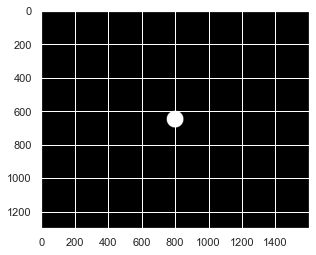

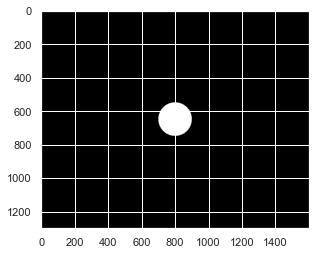

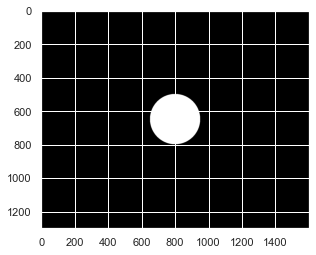

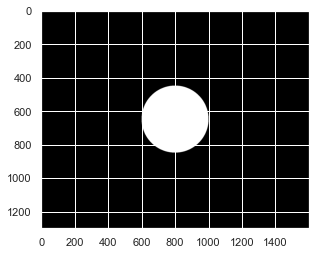

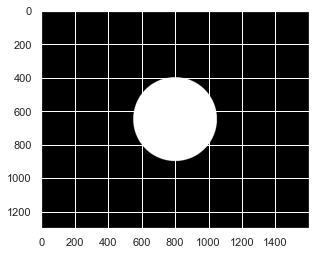

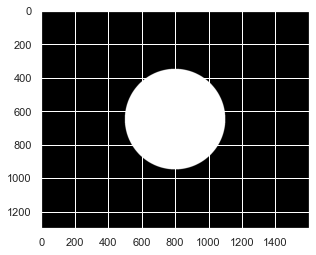

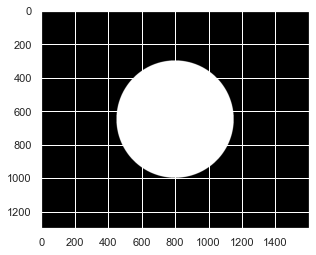

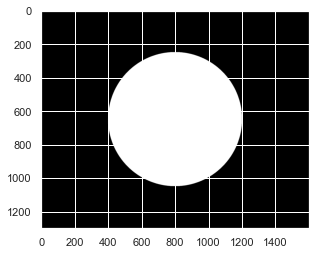

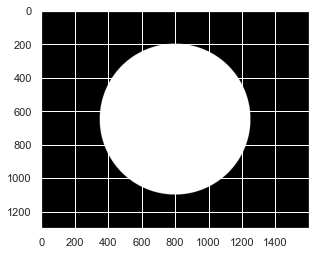

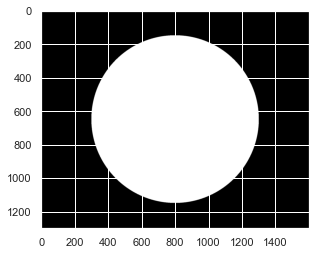

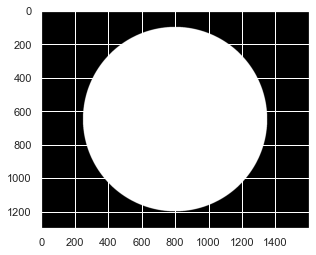

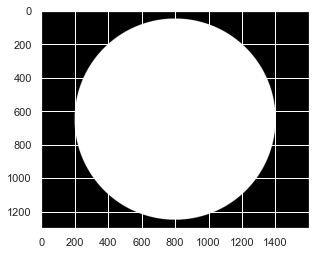

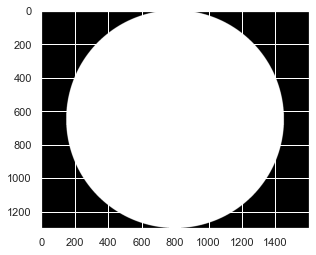

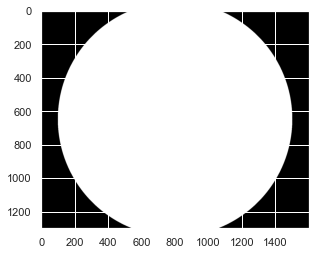

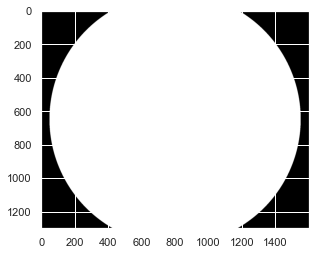

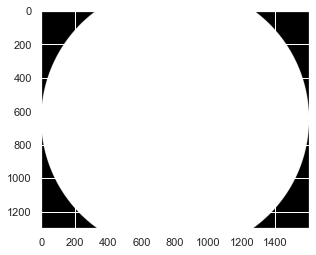

In [24]:
# n = 半径のピクセル
n = 50

# 円の数
cn = int(800/n)
print("cn="+str(cn))

clist = [np.zeros((1300,1600)) for a in range(cn)]

for m in range(len(clist)):
    cv2.circle(clist[m], (800,650), n*(m+1), (255,255,255), thickness = -1, lineType = cv2.LINE_8)
    showimg(clist[m])

clist_bool = [clist[m]==255 for m in range(len(clist)) ]

In [32]:
mask_bool = (mask==255)

In [37]:
wakkanames = []
wakkamasks = []
for m in range(len(clist)-1):
    wakkanames.append("No.{}".format(m+1))
    to_append = (clist_bool[m]^clist_bool[m+1])&(mask_bool)
    wakkamasks.append(to_append)

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■

In [39]:
ndslist = []
avelist = []

In [40]:
for vi in VIlist:

    nd_s = []
    df_s = []
    for m in range(len(wakkamasks)):
        a = vi[wakkamasks[m]].flatten()
        nd_s.append(a)
        df_s.append(pd.DataFrame(a))
    
    dfs = pd.concat(df_s, axis = 1)
    dfs.columns = wakkanames
    
    ndslist.append(nd_s)
    avelist.append(dfs.describe().iloc[1])

<img src = "./figures/box.png" width = "500">

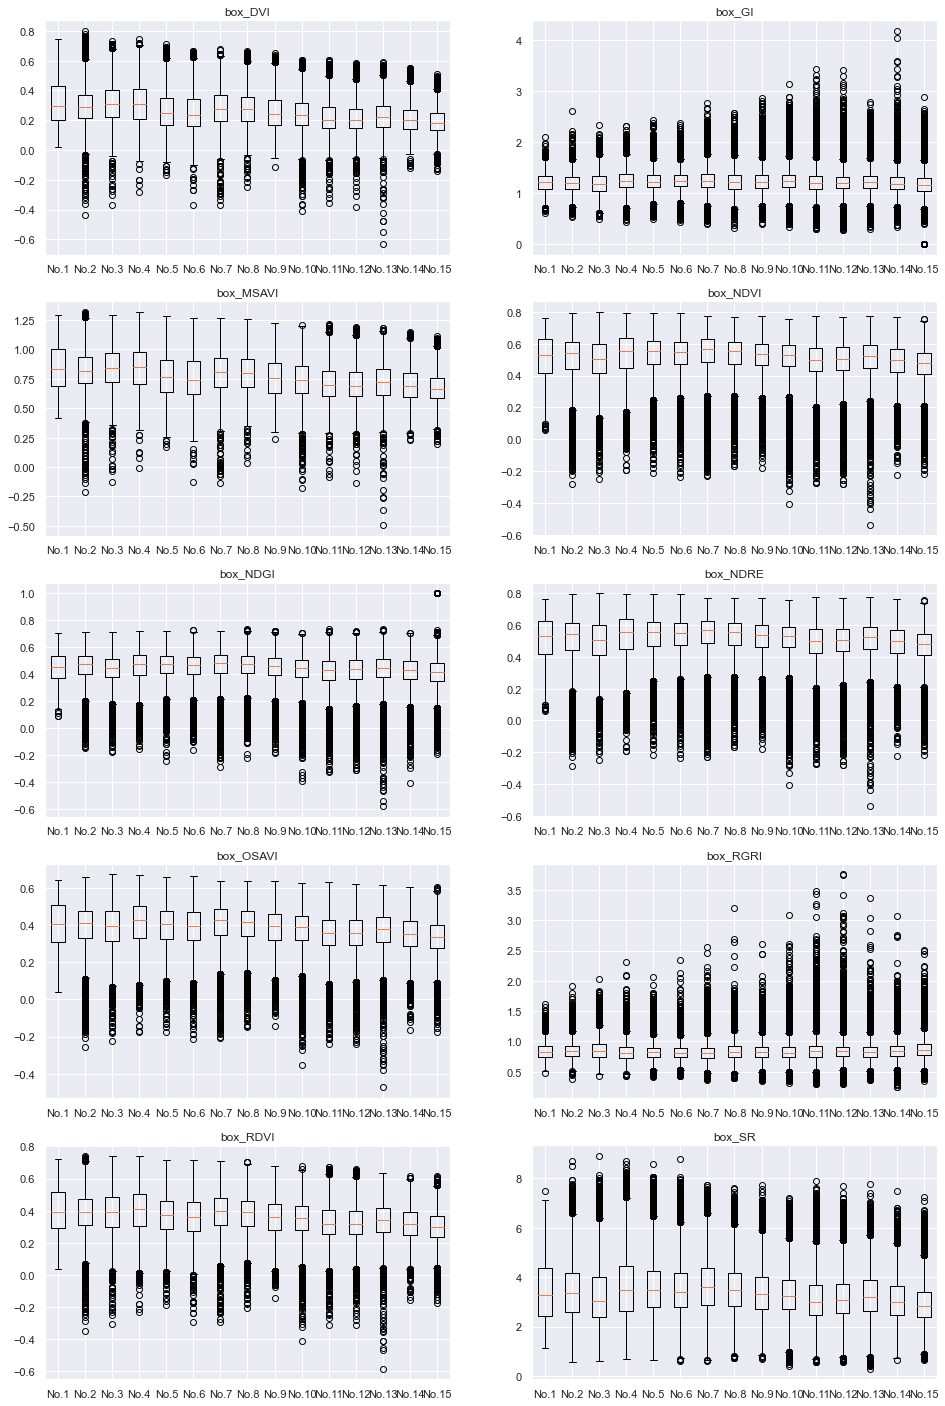

In [54]:
# pandasDataFrameはNaNがあると箱ひげ図を描画してくれないのでndarrayのリストを別に作ってboxplotメソッドに渡している．

fig, axes = plt.subplots(5,2, figsize=(16,25))
for k in range(5):
    for l in range(2):
        axes[k][l].set_title("box_"+VIname[2*k+l])
        axes[k][l].boxplot(ndslist[2*k+l], labels=wakkanames)
plt.show()
fig.savefig(rootpath + "/bunpu_result/boxplot_{}0.png".format(imgNo), dpi=200)

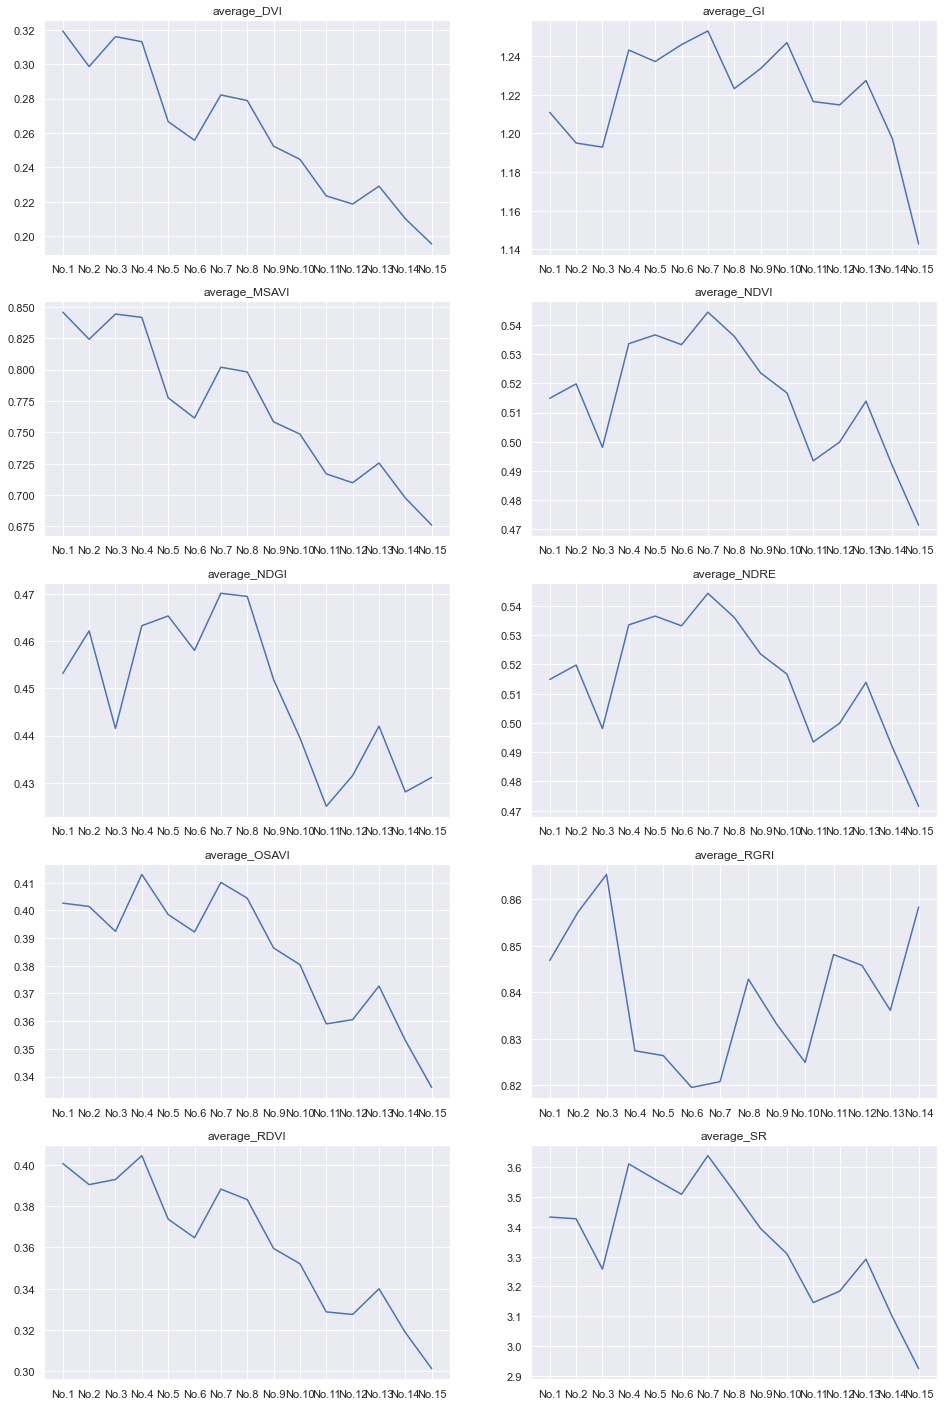

In [51]:

fig, axes = plt.subplots(5,2, figsize=(16,25))
for k in range(5):
    for l in range(2):
        axes[k][l].set_title("average_"+VIname[2*k+l])
        axes[k][l].plot(wakkanames, avelist[2*k+l])
plt.show()
fig.savefig(rootpath + "/bunpu_result/average_{}0.png".format(imgNo), dpi=200)